##### the goal is here to see what changes between baseline and baseline-2snaps, in an attempt to understand why i-band depth stddev is better in the latter as compared to the former.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os
import pandas as pd
%matplotlib inline

In [2]:
import time
import copy
import numpy as np
import healpy as hp
import os
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

import lsst.sims.maf.maps as maps

In [3]:
%matplotlib inline

In [4]:
fontsize = 18
rcparams = {}
rcparams['figure.figsize'] = (10, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 2
rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize'%axis] = fontsize-2
    rcparams['%stick.direction'%axis] = 'in'
    rcparams['%stick.major.size'%axis] = 5.5
    rcparams['%stick.minor.size'%axis] =  3.5
    rcparams['%stick.major.width'%axis] = 2
    rcparams['%stick.minor.width'%axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True
for key in rcparams: mpl.rcParams[key] = rcparams[key]

In [5]:
nside = 256
area_ppixel = hp.nside2pixarea(nside=nside, degrees=True)

dbdir = '/global/cscratch1/sd/awan/dbs_post_wp_v3'

dbnames =[f for f in os.listdir(dbdir) if f.__contains__('baseline') ]
print(dbnames)

['baseline_2snapsv1.4_10yrs.db', 'baseline_v1.4_10yrs.db']


In [6]:
outdir = 'tests'

In [7]:
bundles_all = {}

In [8]:
colname = 'seeingFwhmEff'

 # consider only non-DD visits
sqlconstraint = ' note not like "DD%"'
sqlconstraint += ' and filter=="i"'

resultsDb = db.ResultsDb(outDir=outdir)

for dbname in dbnames:
    bundles = {}
    
    dbpath = '%s/%s' % (dbdir, dbname)

    opsdb = db.OpsimDatabase(dbpath)
    # set up slicer
    slicer = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec',
                                   latLonDeg=opsdb.raDecInDeg, nside=nside, useCache=False)
    
    # set up the mean metric
    metric = metrics.MeanMetric(col=colname)
    # setup the bundle
    bundles['mean'] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
     # set up the mean metric
    metric = metrics.MedianMetric(col=colname)
    # setup the bundle
    bundles['median'] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    
    # set up the mean metric
    metric = metrics.RmsMetric(col=colname)
    # setup the bundle
    bundles['rms'] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # set up the group.
    grp = metricBundles.MetricBundleGroup(bundles, opsdb, outDir=outdir,
                                          resultsDb=resultsDb, saveEarly=False)
    grp.runAll()

    for key in bundles:
        bundles_all['%s - %s' % (dbname.split('.db')[0], key)] = copy.deepcopy(bundles[key])

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" and filter=="i" for columns ['fieldRA', 'seeingFwhmEff', 'fieldDec']
Found 403918 visits
Running:  ['mean', 'median', 'rms']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" and filter=="i" for columns ['fieldRA', 'seeingFwhmEff', 'fieldDec']
Found 437227 visits
Running:  ['mean', 'median', 'rms']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [9]:
dbnames = ['%s' % db.split('.db')[0] for db in dbnames]
dbnames

['baseline_2snapsv1.4_10yrs', 'baseline_v1.4_10yrs']

In [10]:
stats = ['mean', 'median', 'rms']

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2020_05/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


<Figure size 720x432 with 0 Axes>

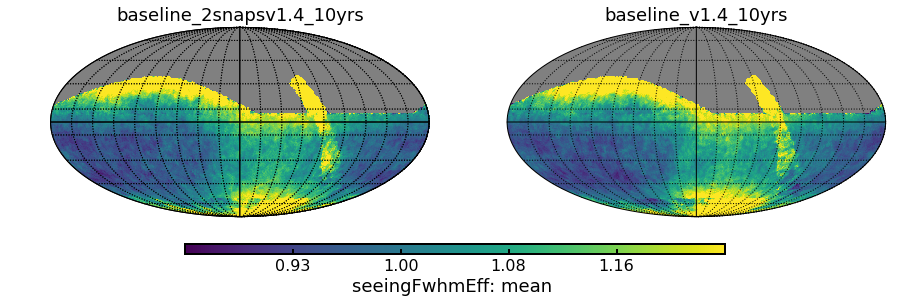

<Figure size 720x432 with 0 Axes>

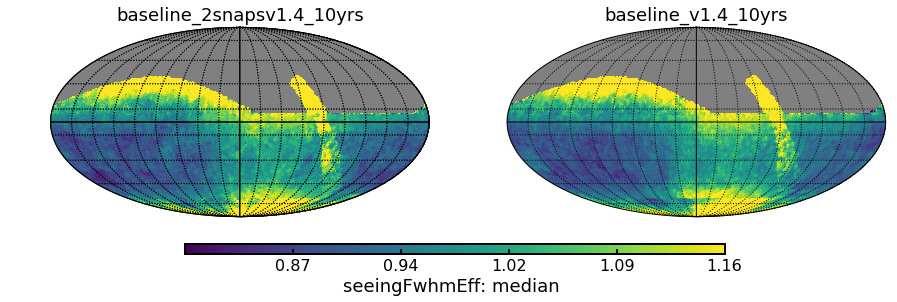

<Figure size 720x432 with 0 Axes>

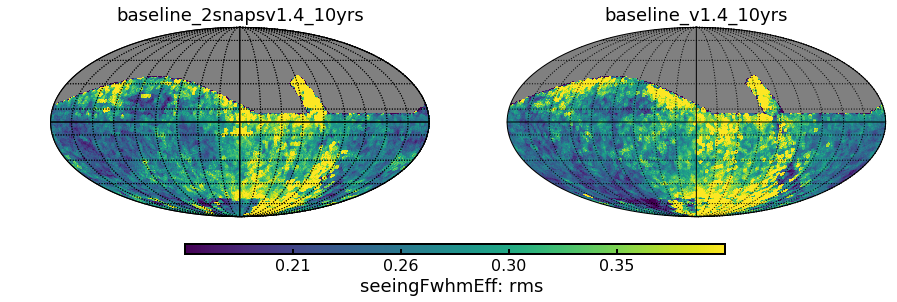

In [11]:
cmin, cmax = None, None

for stat in stats:
    
    plt.clf()
    fig, axes= plt.subplots(1,2)
    for i, dbname in enumerate( dbnames ):

        key = '%s - %s' % (dbname, stat)
        
        if i == 0:
            in_survey_pixels = np.where( bundles_all[key].metricValues.mask == False )[0]
            # find the color range
            median = np.median(bundles_all[key].metricValues.data[in_survey_pixels])
            stddev = np.std(bundles_all[key].metricValues.data[in_survey_pixels])

            colormin = median - 1.5 * stddev
            colormax = median + 1.5 * stddev
            nticks = 5

        plt.axes(axes[i])
        hp.mollview(bundles_all[key].metricValues, flip='astro', rot=(0,0,0),
                    min=colormin, max=colormax, hold=True,
                    cbar=False, title=dbname)
        hp.graticule(dpar=20, dmer=20, verbose=False)

    # set up the color bar
    increment = (colormax - colormin) / float(nticks)
    ticks = np.arange(colormin + increment, colormax, increment)

    ax = plt.gca()
    im = ax.get_images()[0]
    fig= plt.gcf()
    cbaxes = fig.add_axes([0.25, 0.38, 0.5, 0.01]) # [left, bottom, width, height]
    cb = plt.colorbar(im, orientation='horizontal',
                      ticks=ticks, format='%.2f', cax=cbaxes
                     )
    cb.set_label('%s: %s ' % (colname, stat) )
    fig.set_size_inches(15,15)
    plt.show()

#### look at things in the eg-footprint

In [12]:
eg_dir = '/global/cscratch1/sd/awan/lsst_output/post_wp_output_v1.4_-0.1cuts/lss_fom/eg-footprint-mask/'
yr_cut = '10'

eg_masks = {}
for dbname in dbnames:
    dbname = dbname.split('.db')[0]
    print(dbname)
    file = [f for f in os.listdir(eg_dir) if f.__contains__('eg-footprint_%s' % dbname) and \
                                                f.__contains__('_yr%s_' % yr_cut)
           ]
    print(file)
    
    eg_masks[dbname] = np.genfromtxt('%s/%s' % (eg_dir, file[0]))

baseline_2snapsv1.4_10yrs
['eg-footprint_baseline_2snapsv1.4_10yrs_yr10_i>25.9_NoDither_nside256.txt']
baseline_v1.4_10yrs
['eg-footprint_baseline_v1.4_10yrs_yr10_i>25.9_NoDither_nside256.txt']


<Figure size 720x432 with 0 Axes>

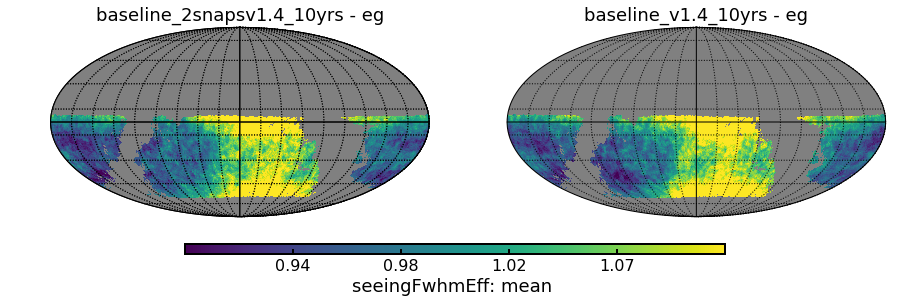

<Figure size 720x432 with 0 Axes>

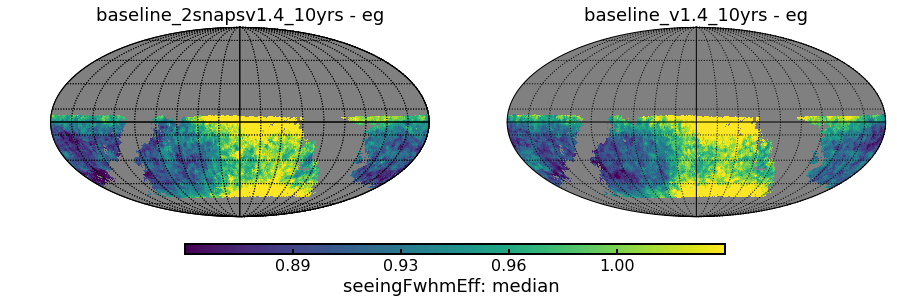

<Figure size 720x432 with 0 Axes>

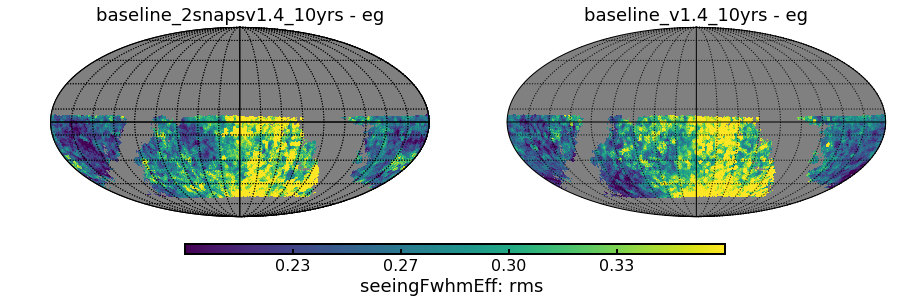

In [13]:
for stat in stats:
    
    plt.clf()
    fig, axes= plt.subplots(1,2)
    for i, dbname in enumerate( dbnames ):

        key = '%s - %s' % (dbname, stat)
        
        temp = copy.deepcopy( bundles_all[key] )
        temp.metricValues.mask[:] = eg_masks[dbname].astype(bool)
        
        if i == 0:
            in_survey_pixels = np.where( temp.metricValues.mask == False )[0]
            # find the color range
            median = np.median(temp.metricValues.data[in_survey_pixels])
            stddev = np.std(temp.metricValues.data[in_survey_pixels])

            colormin = median - 1.5 * stddev
            colormax = median + 1.5 * stddev
            nticks = 5

        plt.axes(axes[i])
        hp.mollview(temp.metricValues, flip='astro', rot=(0,0,0),
                    min=colormin, max=colormax, hold=True,
                    cbar=False, title='%s - eg' % dbname)
        hp.graticule(dpar=20, dmer=20, verbose=False)

    # set up the color bar
    increment = (colormax - colormin) / float(nticks)
    ticks = np.arange(colormin + increment, colormax, increment)

    ax = plt.gca()
    im = ax.get_images()[0]
    fig= plt.gcf()
    cbaxes = fig.add_axes([0.25, 0.38, 0.5, 0.01]) # [left, bottom, width, height]
    cb = plt.colorbar(im, orientation='horizontal',
                      ticks=ticks, format='%.2f', cax=cbaxes
                     )
    cb.set_label('%s: %s ' % (colname, stat) )
    fig.set_size_inches(15,15)
    plt.show()

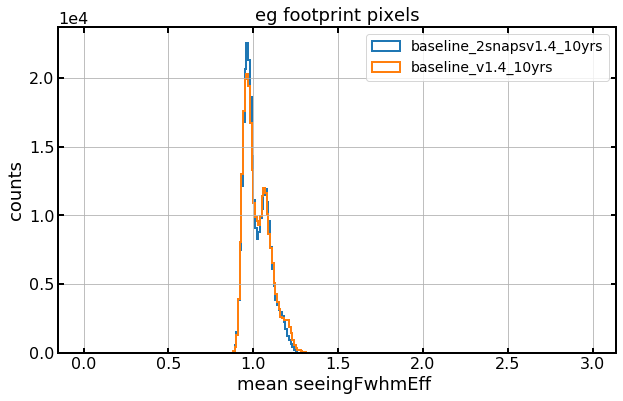

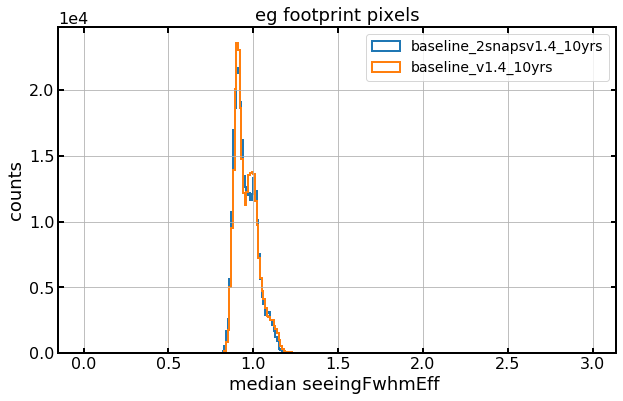

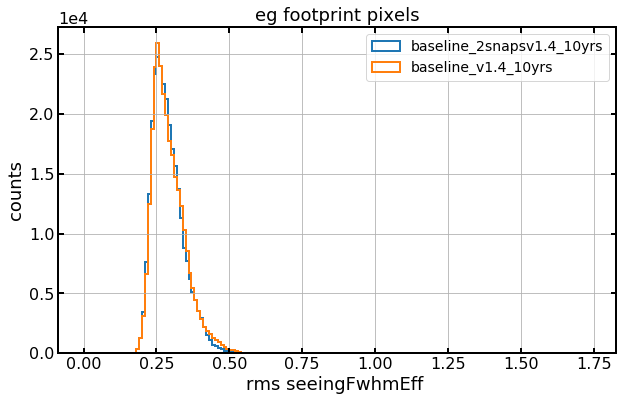

In [14]:
for stat in stats:
    if stat == 'mean' or stat == 'median':
        bins = np.arange(0, 3, 0.01)
    if stat == 'rms':
        bins = np.arange(0, 1.75, 0.01)

    plt.clf()
    for i, dbname in enumerate( dbnames ):

        key = '%s - %s' % (dbname, stat)
        in_survey_pixels = np.where( eg_masks[dbname] == False )[0]
        
        plt.hist(bundles_all[key].metricValues.data[in_survey_pixels], label=dbname, histtype='step', lw=2, bins=bins)

    plt.legend()
    plt.xlabel('%s %s ' % (stat, colname))
    plt.ylabel('counts')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.title('eg footprint pixels')
    plt.show()

#### okay there appear to be differences in seeing between the two versions. the mean seeing and the rms is slightly better in 2snaps vs. not.